In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Insights on the data

In [3]:
# Weekly_Sales is the target a continuous variable we are in a continuous problem
df = pd.read_csv("Walmart_Store_sales.csv")
print (df.shape)
df.head()

(150, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [4]:
df.nunique()

Store            20
Date             85
Weekly_Sales    136
Holiday_Flag      2
Temperature     130
Fuel_Price      120
CPI             135
Unemployment    104
dtype: int64

In [5]:
print(f"There's a total of {df.isna().sum().sum()} Nans")
df.isna().sum()

There's a total of 103 Nans


Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

In [6]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


In [7]:
columns_to_check = ['Weekly_Sales', 'Date']
df = df.dropna(subset=columns_to_check)

In [8]:
df[['Day', 'Month', 'Year']] = df['Date'].str.split('-', expand=True)
df['Day'] = pd.to_numeric(df['Day'])
df['Month'] = pd.to_numeric(df['Month'])
df['Year'] = pd.to_numeric(df['Year'])
df =df.drop(columns= "Date")

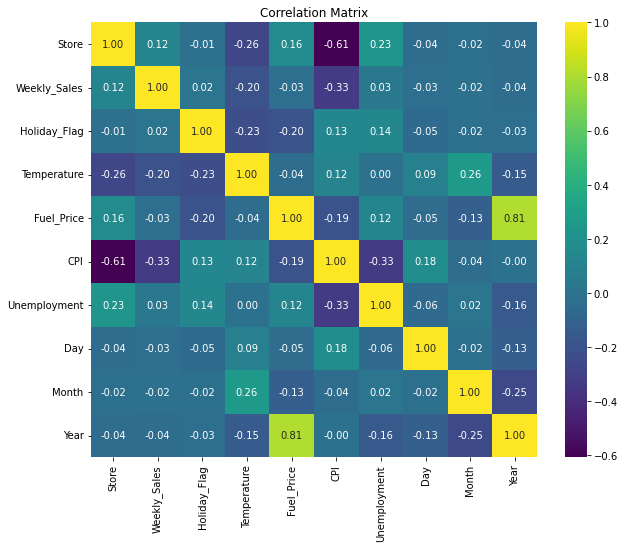

In [9]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

c:\Users\guijarro\Miniconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 576x432 with 0 Axes>

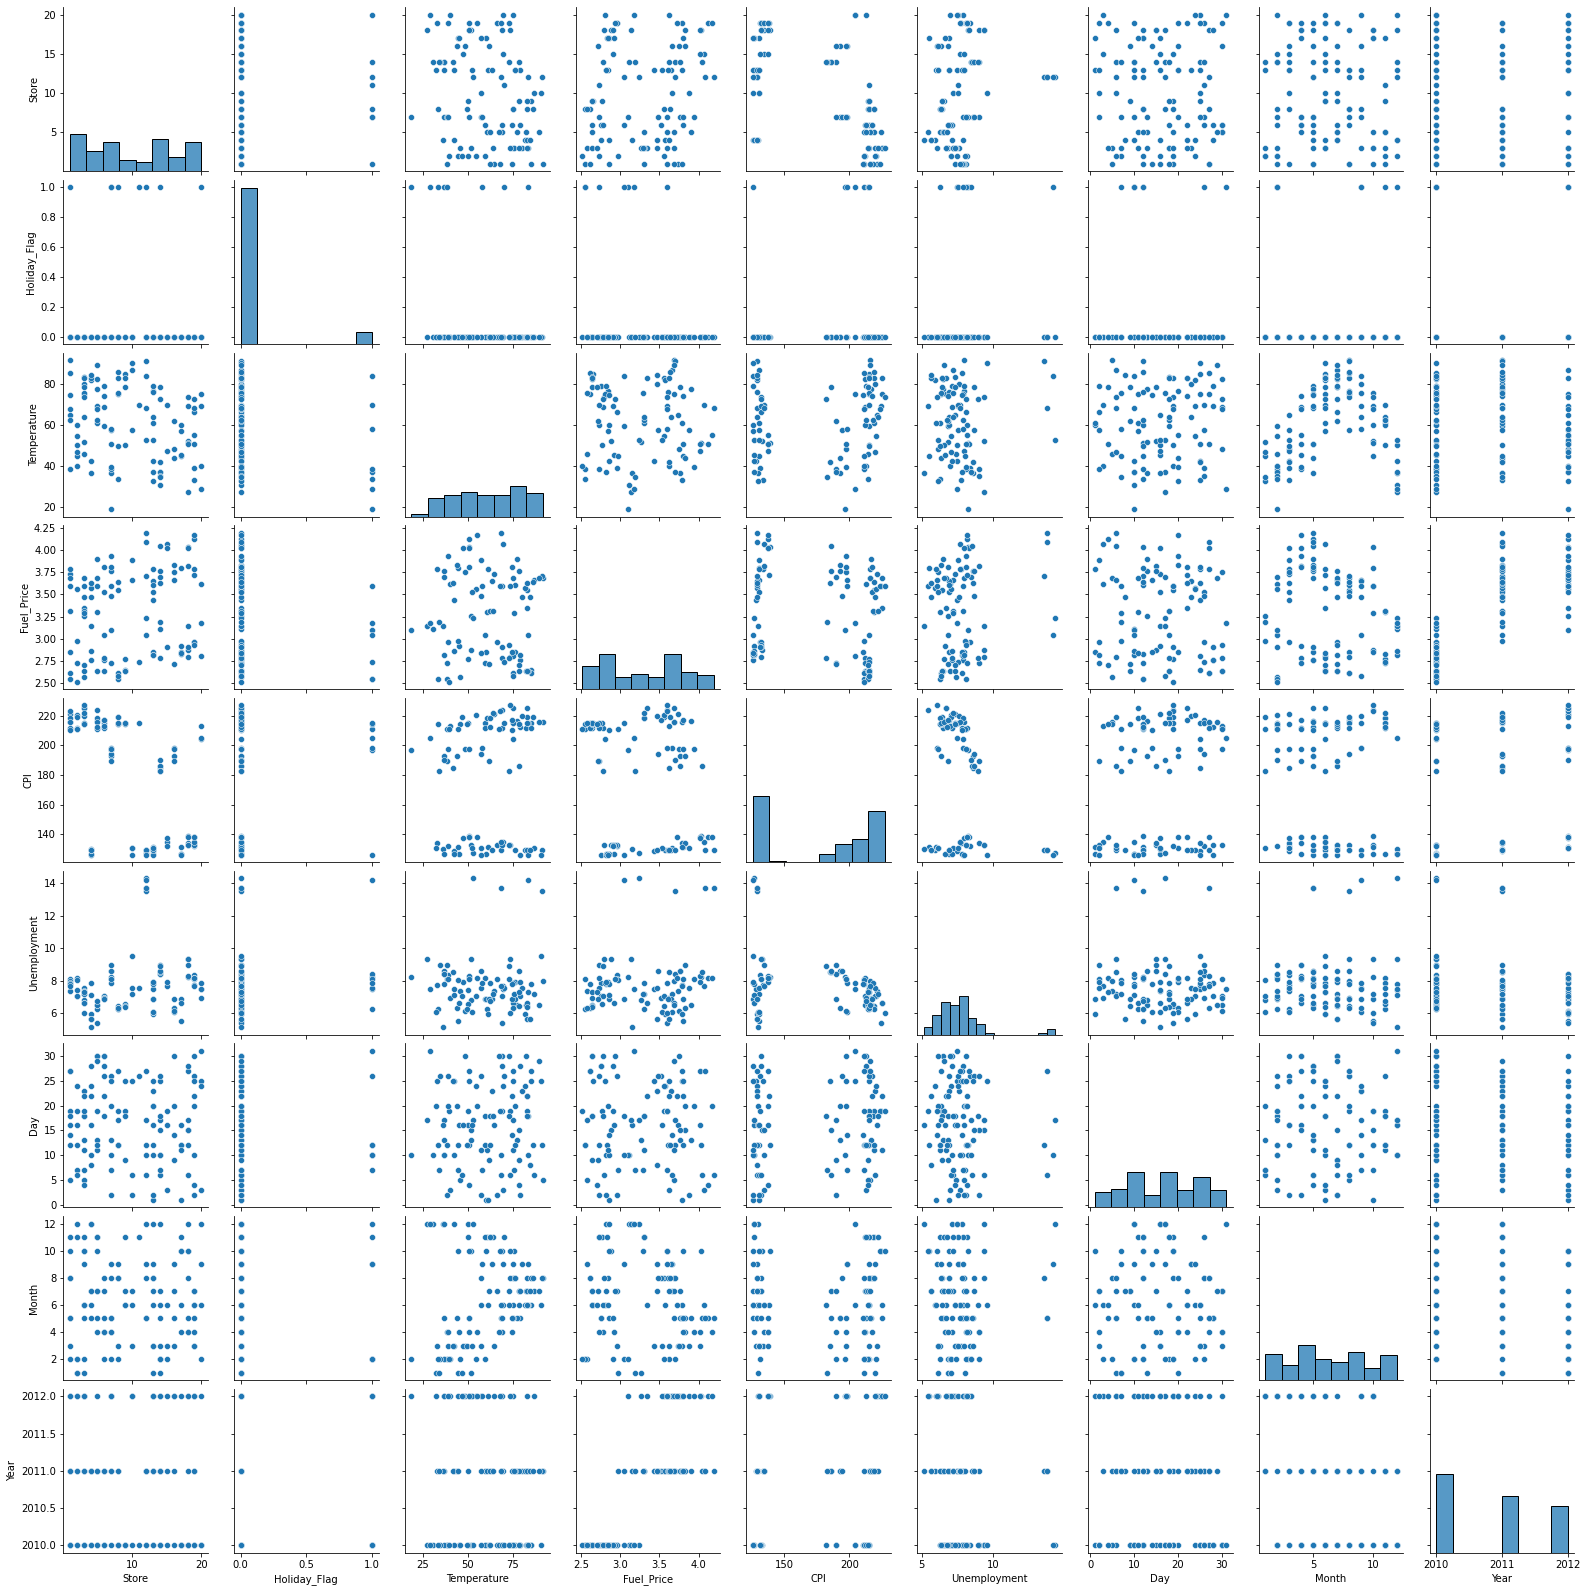

In [10]:
features = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
            'CPI', 'Unemployment', 'Day', 'Month', 'Year']
plt.figure(figsize=(8, 6))  # Set the figure size
sns.pairplot(df[features])

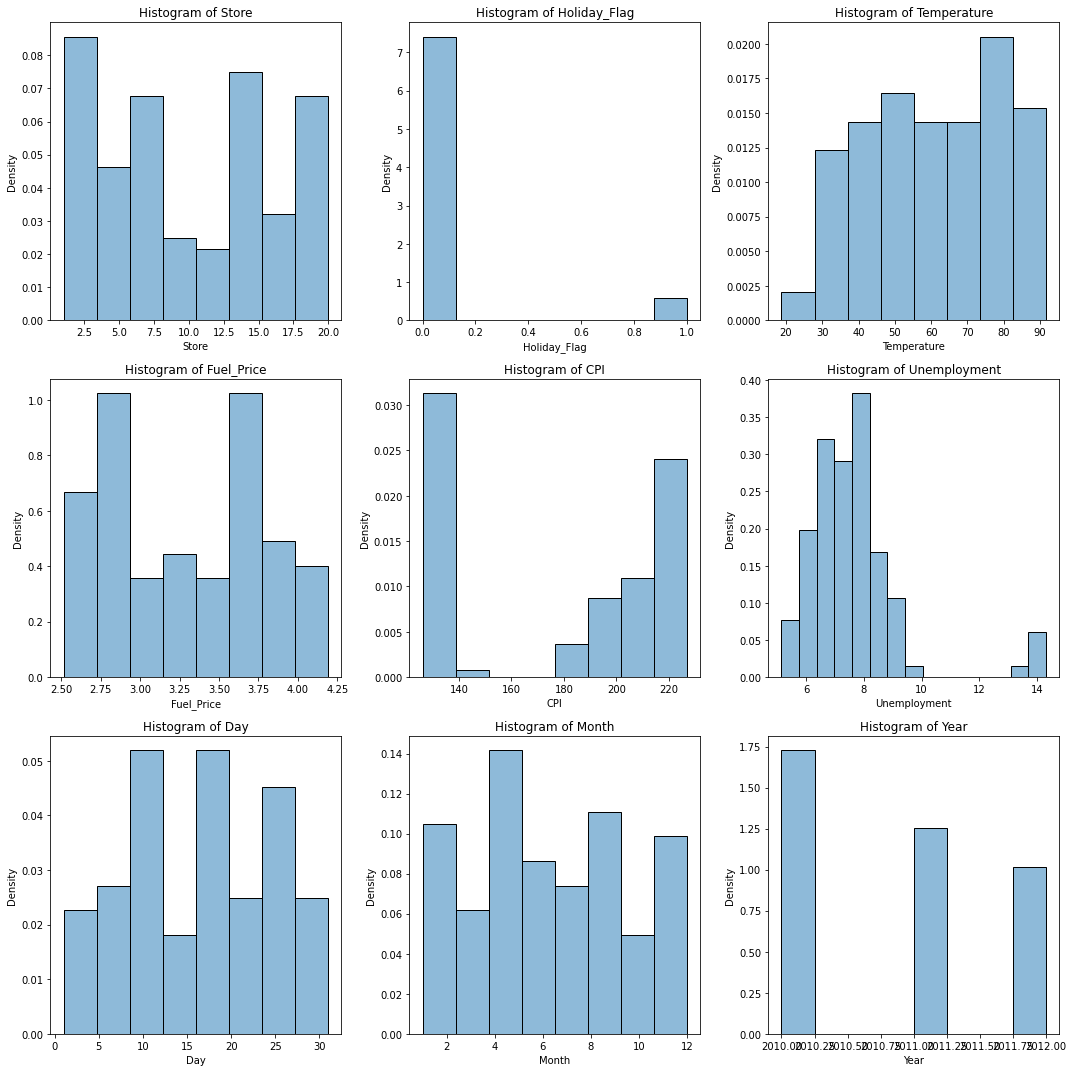

In [11]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, ax=axes[i], kde=False, stat='density', alpha=0.5)
    axes[i].set_title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

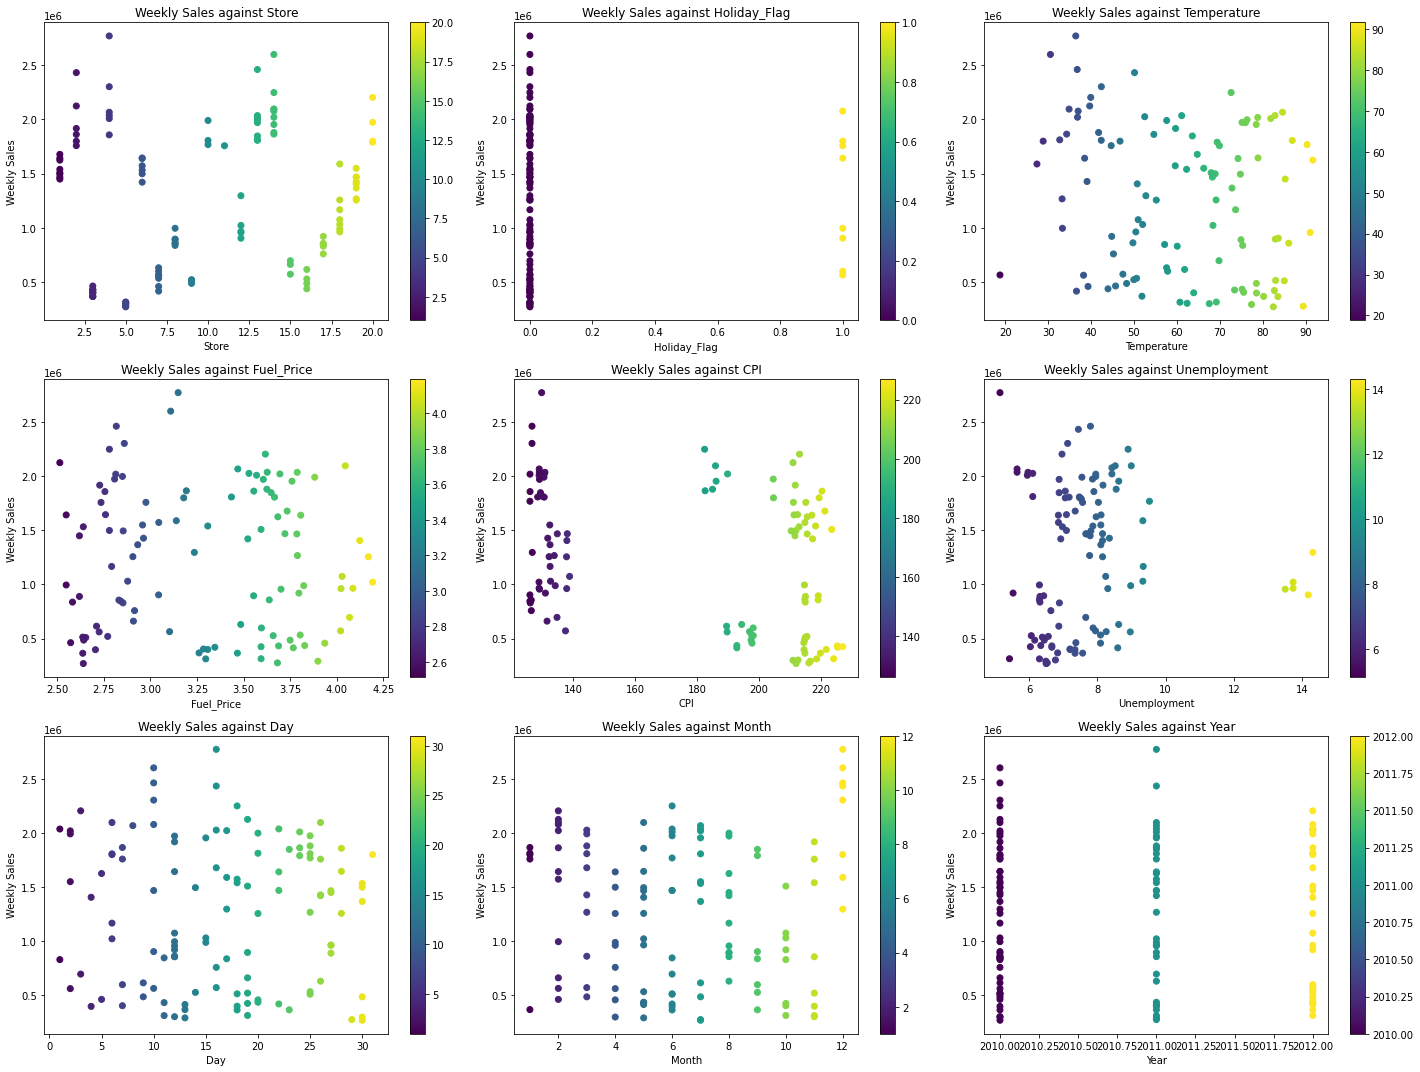

In [12]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 10})
nrows = 3
ncols = 3

# Iterate through each column and create a subplot
for i, column in enumerate(features):
    plt.subplot(nrows, ncols, i + 1)
    color_values = df[column]
    plt.scatter(x=df[column], y=df["Weekly_Sales"], c=color_values)
    plt.title(f'Weekly Sales against {column}')
    plt.xlabel(column)
    plt.ylabel("Weekly Sales")
    plt.colorbar()

# Show the plots
plt.tight_layout()
plt.show()

### Deletion of outliers 

In [14]:
features =["Temperature",  "Unemployment"]
means = df[features].mean()
stds = df[features].std()
#Remove outliers for each column
for i in features:
    lower_bound = means[i] - 3 * stds[i]
    upper_bound = means[i] + 3 * stds[i]
    df = df[(df[i] >= lower_bound) & (df[i] <= upper_bound)]
print()

# Model
## Create a  model that predict the Weekly sales 

### Linear regression model

In [38]:
target_name = "	Weekly_Sale"
X = df.drop(target_variable, axis=1)
Y = df[target_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=0)

In [ ]:
# Define numeric and categorical features
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", 'Day', 'Month', 'Year', "Store", "Weekly_Sales"]
categorical_features = ["Holiday_Flag"]

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])

In [44]:
# Define numeric and categorical features
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", 'Day', 'Month', 'Year']
categorical_features = ["Holiday_Flag", "Store"]

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features)])

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
# Transform the test data
X_test_preprocessed = preprocessor.transform(X_test)

# THE MODEL
model = LinearRegression()
model.fit(X_train_preprocessed, Y_train)

# Make predictions
Y_test_pred = model.predict(X_test_preprocessed)
Y_train_pred = model.predict(X_train_preprocessed)

# Calculate MSE on the train set
train_mse = mean_squared_error(Y_train, Y_train_pred)
print("Train Mean Squared Error:", train_mse)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_test_pred)
print("Test Mean Squared Error:", mse)

train_r2_score = model.score(X_train_preprocessed, Y_train)
print("Train R2 Score:", train_r2_score)

# Compute R^2 score on the test set
test_r2_score = model.score(X_test_preprocessed, Y_test)
print("Test R2 Score:", test_r2_score)

Train Mean Squared Error: 6052777885.445226
Test Mean Squared Error: 225951847607.7736
Train R2 Score: 0.9897279282354128
Test R2 Score: 0.4347845403301338


##### The mse errors and the R2 scores show that the model performs well on the training data but poorly on the test data. This large discrepancy show that the model is overfitting

In [45]:
coefficients = model.coef_
# Printing coefficients along with feature names
for feature, coef in zip(X_train.columns, coefficients):
    print(f"{feature}: {coef}")

Store: -33073.626359000955
Holiday_Flag: 14855.961400727101
Temperature: -214248.688609909
Fuel_Price: 1558.038618980894
CPI: -16590.73440321492
Unemployment: 105307.64504454649
Day: -12287.892880674712
Month: -58981.94121429756
Year: 58981.94121429739


##### According to the coefficients: Fuel price, holiday flag, unemployment and year have a positive impact: if they increase the, target also increase. However, store, holiday flag, temperature, CPI , day and month have an inverse impact , the more they increase the more the target decrease

# Ridge Model to fight overfitting

##### Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
 Calculating the mean error on the cross-validated score allow to conclude whether there is siginificative difference
 between the R2 train and test in the model

In [56]:
# Define the Ridge regression model
ridge_model = Ridge()
alphas = [0.01,0.05, 0.1, 0.5, 1, 10, 100, 500]
param_grid = {'alpha': alphas}

# Perform cross-validation with grid search
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_preprocessed, Y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best Parameters:", grid_search.best_params_)

# Instantiate the Ridge regression model with the best alpha
ridge_model_best = Ridge(alpha=best_alpha)
ridge_model_best.fit(X_train_preprocessed, Y_train)

# Make predictions
Y_test_pred = ridge_model_best.predict(X_test_preprocessed)
Y_train_pred = ridge_model_best.predict(X_train_preprocessed)

# Calculate MSE on the train and test set
train_mse = mean_squared_error(Y_train, Y_train_pred)
test_mse = mean_squared_error(Y_test, Y_test_pred)
print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)

# Compute R^2 score on the train and test set
train_r2_score = ridge_model_best.score(X_train_preprocessed, Y_train)
test_r2_score = ridge_model_best.score(X_test_preprocessed, Y_test)
print("Train R2 Score:", train_r2_score)
print("Test R2 Score:", test_r2_score)

Best Parameters: {'alpha': 0.1}
Train Mean Squared Error: 7553965123.864621
Test Mean Squared Error: 256393497888.51285
Train R2 Score: 0.9871802875757073
Test R2 Score: 0.35863516806916806


### There is still overfitting

# Lasso model to fight overfitting 

In [72]:
# Define the Lasso regression model
lasso_model = Lasso()
alphas = [0,0.0002,0.001,0.1, 1, 10, 100]
param_grid = {'alpha': alphas}

# Perform cross-validation with grid search
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_preprocessed, Y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best Parameters:", grid_search.best_params_)

# Instantiate the Lasso regression model with the best alpha
lasso_model_best = Lasso(alpha=best_alpha)
lasso_model_best.fit(X_train_preprocessed, Y_train)

# Make predictions
Y_test_pred = lasso_model_best.predict(X_test_preprocessed)
Y_train_pred = lasso_model_best.predict(X_train_preprocessed)

# Calculate MSE on the train and test set
train_mse = mean_squared_error(Y_train, Y_train_pred)
test_mse = mean_squared_error(Y_test, Y_test_pred)
print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)

# Compute R^2 score on the train and test set
train_r2_score = lasso_model_best.score(X_train_preprocessed, Y_train)
test_r2_score = lasso_model_best.score(X_test_preprocessed, Y_test)
print("Train R2 Score:", train_r2_score)
print("Test R2 Score:", test_r2_score)

Best Parameters: {'alpha': 0}
Train Mean Squared Error: 6052777885.445226
Test Mean Squared Error: 208101918122.41394
Train R2 Score: 0.9897279282354128
Test R2 Score: 0.4794358950588443


c:\Users\guijarro\Miniconda3\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\guijarro\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\guijarro\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+10, tolerance: 1.263e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.en

#### This results are better compared with the ridge the R2 train and R2 test are closer , the R2 test is increasing
## Now I will feature selection  to identify the most relevant features for predicting the target, I am going touse lasso as the coeficients indicate their importance

Holiday_Flag, Coefficient: -254786.71237620435
CPI, Coefficient: -214248.68860990612
Month, Coefficient: 105307.64504454649
Temperature, Coefficient: -33073.62635900017
Day, Coefficient: -16590.734403214687
Fuel_Price, Coefficient: 14855.961400725713
Year, Coefficient: -12287.892880673879
Unemployment, Coefficient: 1558.0386189804285
Store, Coefficient: 6.810747705727676e-08


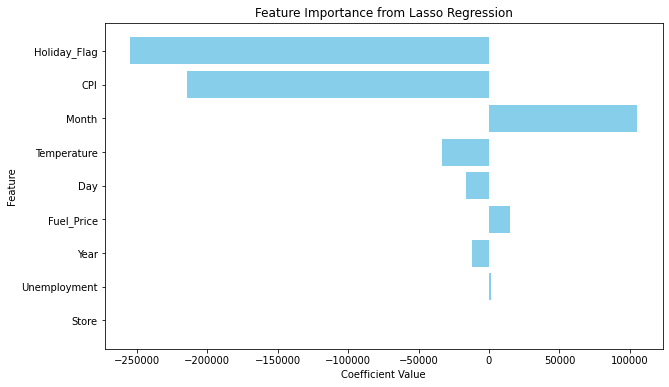

In [80]:
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", 'Day', 'Month', 'Year']
categorical_features = ["Holiday_Flag", "Store"]
feature_names = np.concatenate([numeric_features, categorical_features])
# Get coefficients of the Lasso model
lasso_coefficients = lasso_model_best.coef_

# Associate coefficients with feature names
feature_importance = dict(zip(feature_names, lasso_coefficients))

# Sort feature importance based on absolute coefficient values
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top features and their coefficients
top_features = 10
for feature, coefficient in sorted_feature_importance[:top_features]:
    print(f"{feature}, Coefficient: {coefficient}")

features = [feature for feature, _ in sorted_feature_importance]
coefficients = [coefficient for _, coefficient in sorted_feature_importance]

plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Regression')
plt.gca().invert_yaxis() 
plt.show()

#### According to lasso model the least important features related with the target are Store and Unemployment as their coefficient are closer to 0.
I am going to repeat the process by removing Store from the analysis.

In [79]:
# Define numeric and categorical features
numeric_features = ["Temperature", "Fuel_Price", "CPI",  'Day', 'Month', 'Year']
categorical_features = ["Holiday_Flag"]

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features)])

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
# Transform the test data
X_test_preprocessed = preprocessor.transform(X_test)

# THE MODEL
model = LinearRegression()
model.fit(X_train_preprocessed, Y_train)

# Make predictions
Y_test_pred = model.predict(X_test_preprocessed)
Y_train_pred = model.predict(X_train_preprocessed)

# Calculate MSE on the train set
train_mse = mean_squared_error(Y_train, Y_train_pred)
print("Train Mean Squared Error:", train_mse)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_test_pred)
print("Test Mean Squared Error:", mse)

train_r2_score = model.score(X_train_preprocessed, Y_train)
print("Train R2 Score:", train_r2_score)

# Compute R^2 score on the test set
test_r2_score = model.score(X_test_preprocessed, Y_test)
print("Test R2 Score:", test_r2_score)

Train Mean Squared Error: 338377676061.8487
Test Mean Squared Error: 553373533897.4028
Train R2 Score: 0.42574470138748666
Test R2 Score: -0.3842563344465353


#### If we remove the least important parameters according to Lasso, our model have a lower performance, as both R2 scores decreases and R2test is negative, which means that these features contain important information for predicting the target variable and it is not a good strategy to remove them
- The best strategy is the Lasso with cross validation